### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression

import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Librerías propias
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import shap

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # ssh
# results_dir = "/home/mm/Tesis/pred_results/" # ssh

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'BR_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory already exsist!
Directory created!


In [4]:
for i in ['RandomForest', 'SVM_poly','XGBoost']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory created!
Directory created!
Directory created!


### Data

In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1450, 45), (161, 45))

In [6]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'moca_total', 'aceiii_total', 'mmse_total', 'ifs_total_score',
       'mini_sea_total', 'barthel_total', 'pfeffer_total', 'cdr_sumofboxes',
       'cdr_global', 'npi_total', 'npi_total_caregiver', 'nationality',
       'country_of_residence', 'marital_status', 'n_children',
       'household_members', 'household_income', 'Job_status', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition',
       'functionality', 'income_s_NaN', 'income_s_1', 'income_s_2',
       'income_s_3', 'income_s_4', 'income_s_5', 'income_s_6', 'income_s_7',
       'income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata'],
      dtype='object')

In [7]:
# Bayesian Ridge Imputation ---> Train set
imputed_data = train.copy()
diag_dummies = pd.get_dummies(imputed_data['diagnosis'])
imputed_data = pd.concat([imputed_data, diag_dummies], axis=1)
imputed_data = imputed_data.drop(['site', 'id', 'diagnosis', 'strata'], axis=1)
imputer = IterativeImputer(estimator=BayesianRidge(n_iter=1000))
imputer = imputer.fit(imputed_data)
imputed_data = pd.DataFrame(imputer.transform(imputed_data), columns = imputed_data.columns, index=imputed_data.index )
imputed_data = pd.concat([train[['site', 'id', 'diagnosis', 'strata']], imputed_data], axis=1)
train = imputed_data.copy()
train.isna().sum().sum()

0

In [8]:
# Bayesian Ridge Imputation ---> Test set

imputed_data = test.copy()
diag_dummies = pd.get_dummies(imputed_data['diagnosis'])
imputed_data = pd.concat([imputed_data, diag_dummies], axis=1)
imputed_data = imputed_data.drop(['site', 'id', 'diagnosis', 'strata'], axis=1)
imputer = IterativeImputer(estimator=BayesianRidge(n_iter=1000))
imputer = imputer.fit(imputed_data)
imputed_data = pd.DataFrame(imputer.transform(imputed_data), columns = imputed_data.columns, index=imputed_data.index )
imputed_data = pd.concat([test[['site', 'id', 'diagnosis', 'strata']], imputed_data], axis=1)
test = imputed_data.copy()
test.isna().sum().sum()

0

In [9]:
train.shape, test.shape

((1450, 48), (161, 48))

In [10]:
# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',  'ifs_total_score',
#               'mini_sea_total', 'barthel_total', 'pfeffer_total',  'npi_total', 'npi_total_caregiver',
#               'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition', 'functionality',
#               'marital_status', 'n_children', 'household_members', 'household_income', 'Job_status',
#               'income_s_NaN', 'income_s_1', 'income_s_2', 'income_s_3', 'income_s_4', 'income_s_5',
#               'income_s_6', 'income_s_7','income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata']

final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
              'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
              'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw','ace_vs', 'ace_lw', 'barthel_total',
              'pfeffer_total','cognition', 'functionality', 'marital_status', 'n_children',
              'household_members', 'household_income', 'Job_status', 'strata']

train = train[final_cols]
test = test[final_cols]
    
train.isna().sum()[train.isna().sum()>0]

Series([], dtype: int64)

In [11]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
       'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw',
       'barthel_total', 'pfeffer_total', 'cognition', 'functionality',
       'marital_status', 'n_children', 'household_members', 'household_income',
       'Job_status', 'strata'],
      dtype='object')

In [12]:
train = train.drop(['site','id','strata'], axis=1)
test = test.drop(['site','id','strata'], axis=1)

### Split into AD and FTD
data = train.query("diagnosis != 'CN'")
data['diagnosis'] = data['diagnosis'].replace({'AD':0, 'FTD':1})
data = data.sample(data.shape[0], ignore_index=True)
unseen_data = test.query("diagnosis != 'CN'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'AD':0, 'FTD':1})
unseen_data = unseen_data.sample(unseen_data.shape[0], ignore_index=True)

train.shape, test.shape

((1450, 23), (161, 23))

In [13]:
#### Librerías 
# cambiamos el dir de trabajo
os.chdir("/home/marcelo/GitRepos/Tesis/code") # desktop
# os.chdir("/home/mm/Tesis/code") # ssh

In [14]:
### Load Hyperparams

hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-09-25/BR_hparams/" # Desktop

rf_hp = pd.read_csv(hparams_path + "BR_RF_hparams.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp= rf_hp[rf_hp['mean_test_score'] < rf_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

poly_hp = pd.read_csv(hparams_path + "BR_SVC_Poly_hparams.csv",
                      usecols=['param_C', 'param_coef0', 'param_degree','param_gamma','params', 
                               'mean_test_score' ,'mean_train_score'])
poly_hp= poly_hp[poly_hp['mean_test_score'] < poly_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

xgb_hp = pd.read_csv(hparams_path + "BR_xgb_hparams.csv", usecols=['param_booster', 'param_learning_rate',
       'param_max_bin', 'param_max_depth', 'param_max_leaves',
       'param_n_estimators', 'param_reg_alpha', 'param_reg_lambda',
       'param_tree_method','params', 'mean_test_score' ,'mean_train_score'])
xgb_hp= xgb_hp[xgb_hp['mean_test_score'] < xgb_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

In [15]:
rf_row = 0
rf_hp.iloc[0,:]

param_criterion                                                      entropy
param_max_depth                                                           10
param_max_features                                                        10
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                       500
params                     OrderedDict([('criterion', 'entropy'), ('max_d...
mean_test_score                                                       0.8765
mean_train_score                                                    0.986349
Name: 0, dtype: object

In [16]:
poly_row = 0
poly_hp.iloc[0,: ]

param_C                                                      0.148871
param_coef0                                                         0
param_degree                                                        2
param_gamma                                                  4.898347
params              OrderedDict([('C', 0.14887107527727986), ('coe...
mean_test_score                                              0.826284
mean_train_score                                             0.893643
Name: 0, dtype: object

In [17]:
xgb_row=0
xgb_hp.iloc[0, :]

param_booster                                                     gbtree
param_learning_rate                                             0.135474
param_max_bin                                                          6
param_max_depth                                                        2
param_max_leaves                                                       8
param_n_estimators                                                   100
param_reg_alpha                                                      0.1
param_reg_lambda                                                    0.99
param_tree_method                                                 approx
params                 OrderedDict([('booster', 'gbtree'), ('learning...
mean_test_score                                                 0.853737
mean_train_score                                                0.944803
Name: 0, dtype: object

In [18]:
## Models Hparams
# RF
rf_params= {"n_estimators": rf_hp.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

#Poly
poly_params = {'C': poly_hp.loc[poly_row, "param_C"],
              'gamma': poly_hp.loc[poly_row, "param_gamma"],
               'coef0': poly_hp.loc[poly_row, "param_coef0"],
               'degree': poly_hp.loc[poly_row, 'param_degree'],
              "kernel":"poly","class_weight":"balanced", "verbose":0}

#XGBOOST
xgb_params = {
    'booster': xgb_hp.loc[xgb_row, 'param_booster'],
    'tree_method': xgb_hp.loc[xgb_row, 'param_tree_method'],
    'max_leaves': xgb_hp.loc[xgb_row, 'param_max_leaves'],
    'max_depth': xgb_hp.loc[xgb_row, 'param_max_depth'],
    'max_bin': xgb_hp.loc[xgb_row, 'param_max_bin'],
    'learning_rate': xgb_hp.loc[xgb_row, 'param_learning_rate'],
    'n_estimators': xgb_hp.loc[xgb_row, 'param_n_estimators'],
    'reg_alpha': xgb_hp.loc[xgb_row, 'param_reg_alpha'],
    'reg_lambda': xgb_hp.loc[xgb_row, 'param_reg_lambda'],
    'gamma': 0.005,
    'subsample':1.0,
    'enable_categorical':True, # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
    'n_jobs': -1,
    'verbosity':0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'use_label_encoder':None}

In [19]:
n_iter =1000

### Base model: Logistic Regression

In [20]:
lr_res, lr_CI_df, lr_res_r, lr_ROC_AUC, lr_CM, lr_ROC_chance, lr_empirical_p_value = bc.Bootstrap_linear_classifier(
    data, 'diagnosis', LogisticRegression(), scaler='MM', params='default', test_size=.2, n_iter=n_iter, chance_model=True)

LogisticRegression()


Iterating: 100%|██████████████████| 1000/1000 [03:52<00:00,  4.31it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:3.8677902221679688 minutes
empirical p-value: 0.0



Casting complex values to real discards the imaginary part


In [21]:
lr_res.mean()

Accuracy         0.805169
ROC_AUC          0.813693
Precision        0.759345
Recall           0.258913
Sensitivity      0.258913
Specificity      0.973812
F1               0.382611
Efron_pR2        0.235303
mcfadden_pR2     0.547696
mcfadden_apR2    0.465465
dtype: float64

In [22]:
lr_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci,mcfadden_pR2_ci,mcfadden_apR2_ci
0,0.024549,0.024132,0.026496,0.02715,0.02715,0.009898,0.030124,0.026291,0.030849,0.030916


In [23]:
lr_res_r.head()

,variables,coef_mean,coef_std,T_mean,T_std,p_val_mean,p_val_std
0,Job_status,-0.165841,0.193818,-0.542431+0.000996j,0.638173,0.997316,2.518137e-04
1,ace_lw,0.914971,0.125220,0.000010-0.000005j,0.000009,1.000000,0.000000e+00
2,ace_vs,0.909262,0.125443,0.000010-0.000005j,0.000009,1.000000,0.000000e+00
3,barthel_total,0.320106,0.082930,0.003242-0.000000j,0.000939,0.999358,4.440892e-16
4,cognition,0.446866,0.046421,0.000000+0.000000j,0.000000,1.000000,0.000000e+00


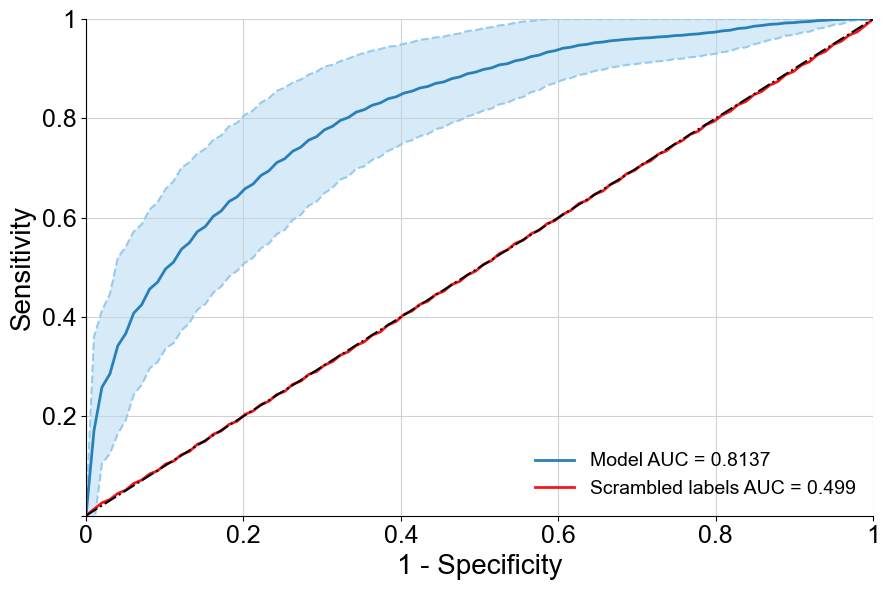

In [24]:
ml_plotting.plot_custom_roc_curve(lr_ROC_AUC, lr_ROC_chance, fname=None)

In [25]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', LogisticRegression(), params='default', test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [26]:
rf_fimp.sort_values('mean', ascending=False)#.to_csv(path_res+ "/RandomForest/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

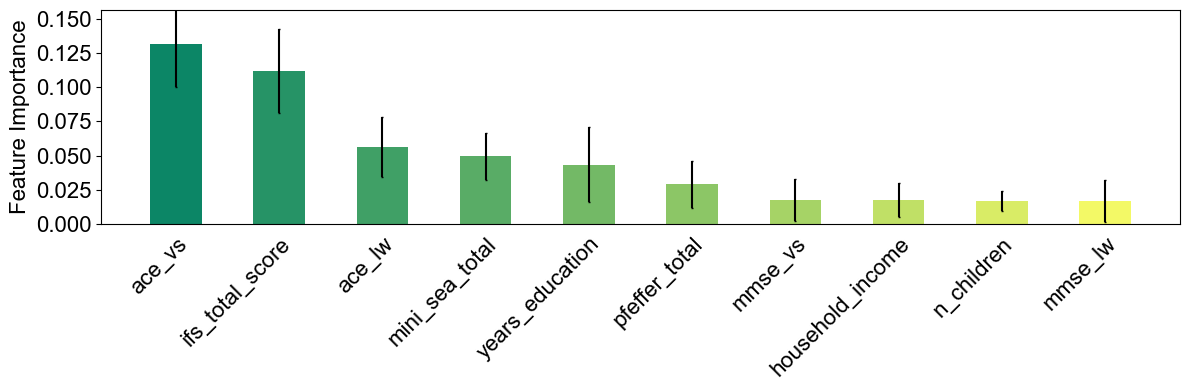

In [27]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

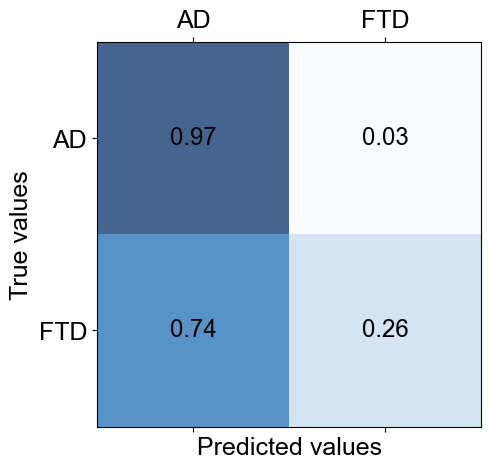

In [28]:
ml_plotting.plot_boostrap_CM(lr_CM, labels=['AD', 'FTD'],fname=None)

#### unseen data

In [29]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [30]:
np.linspace(0.1, 1, num=10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [31]:
# predict & scores
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [32]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
# unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [33]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.559
Accuracy: 0.729
Recall: 0.24
F1: 0.2927
Precision:0.375


In [34]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{lr_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.559
Bootstrping test ROC score: 	0.8137


### RF Model

##### Bootstrap

In [35]:
Model_res, CI_df, Model_res_r, ROC_AUC, CM, ROC_chance, empirical_p_value = bc.Bootstrap_tree_classifier(
    data, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=10, min_samples_leaf=0.01,
                       min_samples_split=0.01, n_estimators=500, n_jobs=-1)


Iterating: 100%|██████████████████| 1000/1000 [56:01<00:00,  3.36s/it]

singular_matrix_errors (droped from results): 0
Eleapsed time:56.02845121224721 minutes
empirical p-value: 0.0


In [36]:
path_res

'/home/marcelo/GitRepos/Tesis/pred_results/2023-11-05/BR_res'

In [37]:
Model_res.to_csv(path_res+ "/RandomForest/Model_res.csv", index=False)
Model_res.mean()

Accuracy       0.825046
ROC_AUC        0.865820
Precision      0.627785
Recall         0.647435
Sensitivity    0.647435
Specificity    0.879879
F1             0.635176
Efron_pR2      0.297620
dtype: float64

In [38]:
print("%.4f" % Model_res['ROC_AUC'].mean())


0.8658


In [39]:
CI_df.to_csv(path_res+ "/RandomForest/CI_df.csv", index=False)
CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.023548,0.021126,0.029961,0.029612,0.029612,0.02015,0.029836,0.028338


In [40]:
Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/RandomForest/Model_res_r.csv", index=False)
Model_res_r.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
20,year_birth,0.204129,0.016268
10,mini_sea_total,0.124715,0.011120
7,household_members,0.058645,0.007648
21,years_education,0.058118,0.009578
9,marital_status,0.056554,0.006383
8,ifs_total_score,0.054056,0.005365
17,npi_total_caregiver,0.053546,0.005757
1,ace_lw,0.042528,0.006984
6,household_income,0.041173,0.004575
15,n_children,0.037771,0.005845


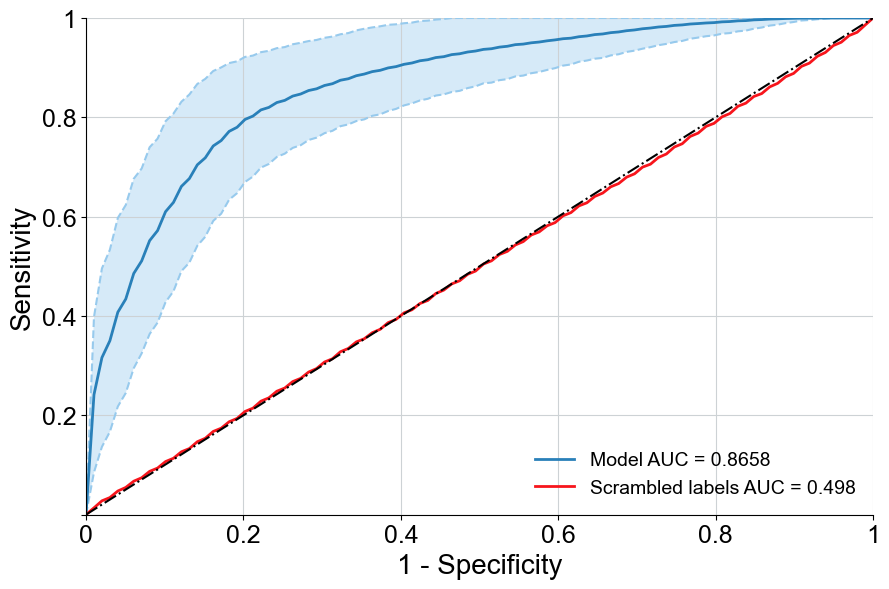

In [41]:
ml_plotting.plot_custom_roc_curve(ROC_AUC, ROC_chance, fname=path_res+ "/RandomForest/ROC_AUC_curve.png")
# Fig save?


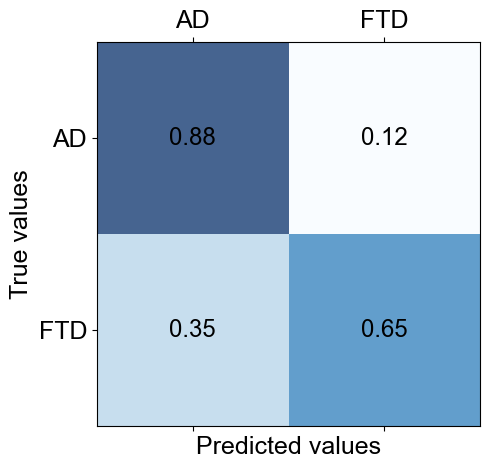

In [42]:
ml_plotting.plot_boostrap_CM(CM, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest/CM.png")

##### Permutation Feature importance

In [43]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', RandomForestClassifier(), params=rf_params, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [44]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

In [45]:
top_10p.head()

,predictor,mean,std
4,mini_sea_total,0.085333,0.017002
0,year_birth,0.054449,0.027234
3,ifs_total_score,0.020198,0.006883
17,marital_status,0.019725,0.005196
19,household_members,0.018317,0.005718


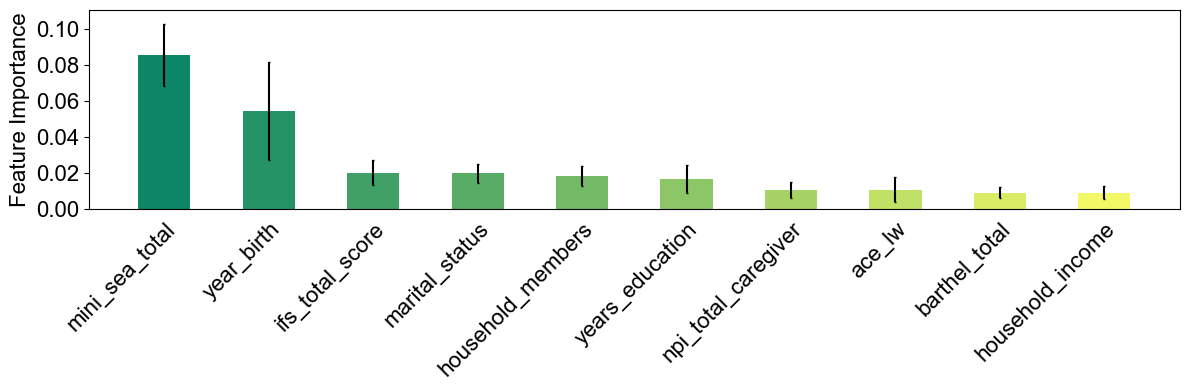

In [46]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

In [47]:
Model_res_r.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
20,year_birth,0.204129,0.016268
10,mini_sea_total,0.124715,0.011120
7,household_members,0.058645,0.007648
21,years_education,0.058118,0.009578
9,marital_status,0.056554,0.006383


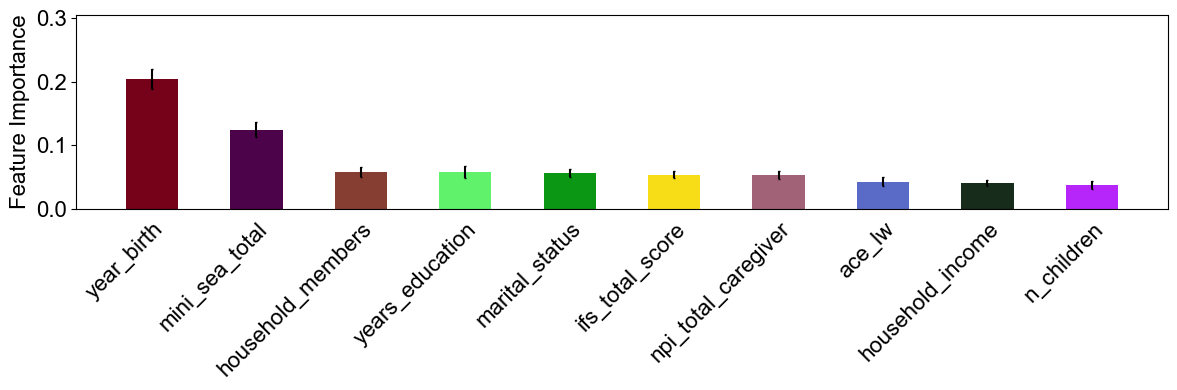

In [48]:
top_10 = Model_res_r.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10, 'variables','Importance_mean', 'Importance_std')

##### unseen data

In [49]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [50]:
# predict & scores
rfc = RandomForestClassifier(**rf_params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)

In [51]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [52]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.719
Accuracy: 0.8037
Recall: 0.56
F1: 0.5714
Precision:0.5833


In [53]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.719
Bootstrping test ROC score: 	0.8658


#### Shapley

In [54]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_test, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


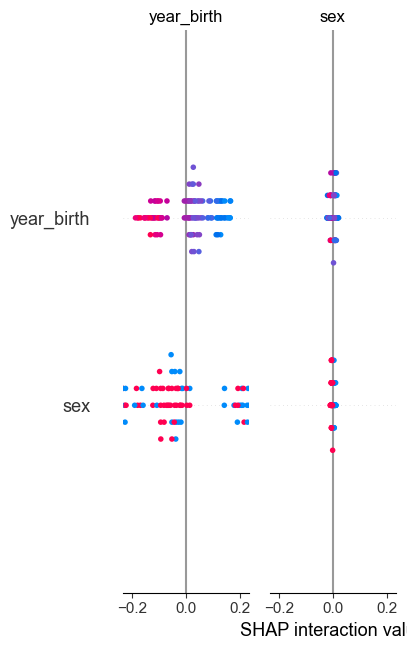

In [55]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

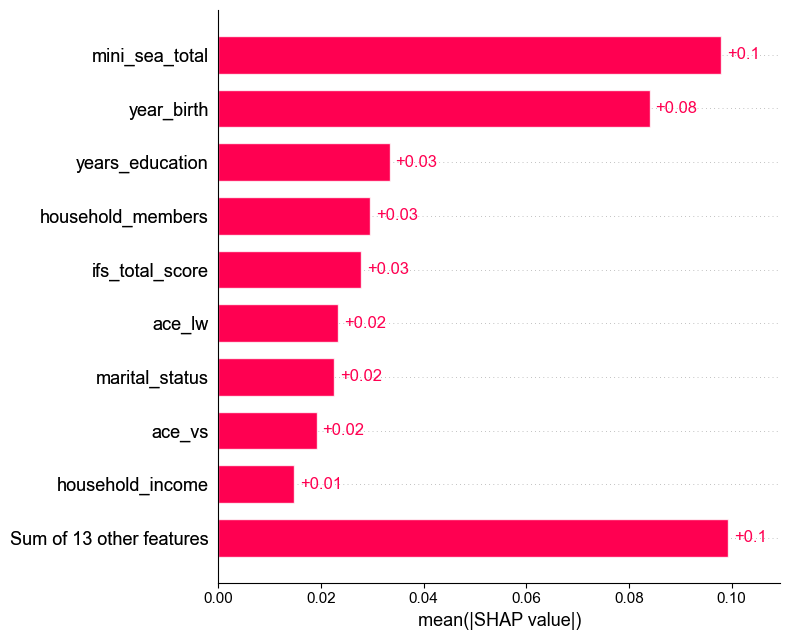

In [56]:
shap.plots.bar(shap_values[:,:,1])

In [57]:
# shap.plots.beeswarm(shap_values[:,:,1])

In [58]:
# # compute SHAP values
# explainer2 = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist())
# shap_values2 = explainer(X_test, check_additivity=False)

In [59]:
# shap.summary_plot(shap_values2[:,:,1])

In [60]:
# shap.plots.bar(shap_values2[:,:,1])

In [61]:

# # Convertir shap_values en un DataFrame
# shap_df = pd.DataFrame(shap_values, columns=X_train.columns.tolist())

# # Guardar el DataFrame en un archivo CSV
# shap_df.to_csv('shap_values.csv', index=False)


In [62]:
# shap_values2[:,:,1]

### SVM - Poly

#### Bootstrap

In [63]:
p_Model_res, p_CI_df, p_Model_res_r, p_ROC_AUC, p_CM, p_ROC_chance, p_empirical_p_value = bc.Bootstrap_SVC_classifier(
    data, 'diagnosis', SVC(), params=poly_params, test_size=.2, scaler='MM', n_iter=n_iter, chance_model=True)

SVC(C=0.1488710752772798, class_weight='balanced', coef0=0, degree=2,
    gamma=4.898346619162522, kernel='poly', verbose=0)


Iterating: 100%|██████████████████| 1000/1000 [01:46<00:00,  9.40it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:1.7733506123224894 minutes
empirical p-value: 0.0


In [64]:
p_Model_res.to_csv(path_res+ "/SVM_poly/poly_Model_res.csv", index=False)
p_Model_res.mean()

Accuracy       0.792077
ROC_AUC        0.773701
Precision      0.546291
Recall         0.738913
Sensitivity    0.738913
Specificity    0.808490
F1             0.626617
dtype: float64

In [65]:
p_CI_df.to_csv(path_res+ "/SVM_poly/poly_CI_df.csv", index=False)
p_CI_df.mean()

Accuracy_ci       0.025153
ROC_AUC_ci        0.025935
Precision_ci      0.030857
Recall_ci         0.027224
Sensitivity_ci    0.027224
Specificity_ci    0.024389
F1_ci             0.029980
dtype: float64

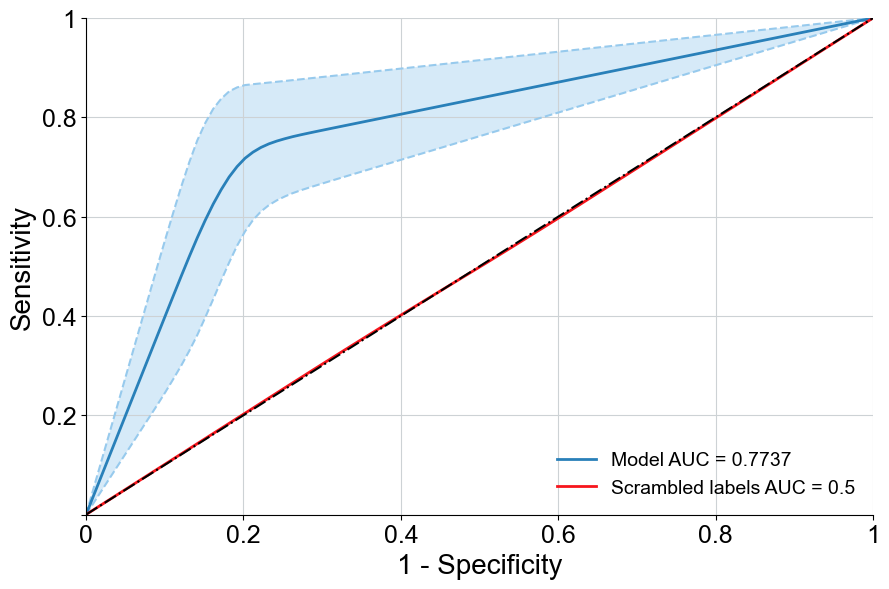

In [66]:
ml_plotting.plot_custom_roc_curve(p_ROC_AUC, p_ROC_chance, fname=path_res+ "/SVM_poly/poly_ROC_AUC_curve.png")

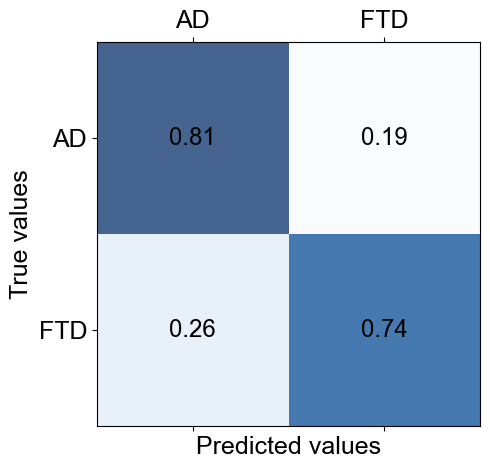

In [67]:
ml_plotting.plot_boostrap_CM(p_CM, labels=['AD', 'FTD'],fname=path_res+ "/SVM_poly/poly_CM.png")

#### Permutation Feature importance

In [68]:
p_fimp = bc.permutation_FIMP( data, 'diagnosis', SVC(), params=poly_params, test_size=.3, n_repeats=n_iter, random_state=123)
p_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/SVM_poly/poly_PFI.csv")
top_10_poly = p_fimp.sort_values('mean', ascending=False).head(10)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


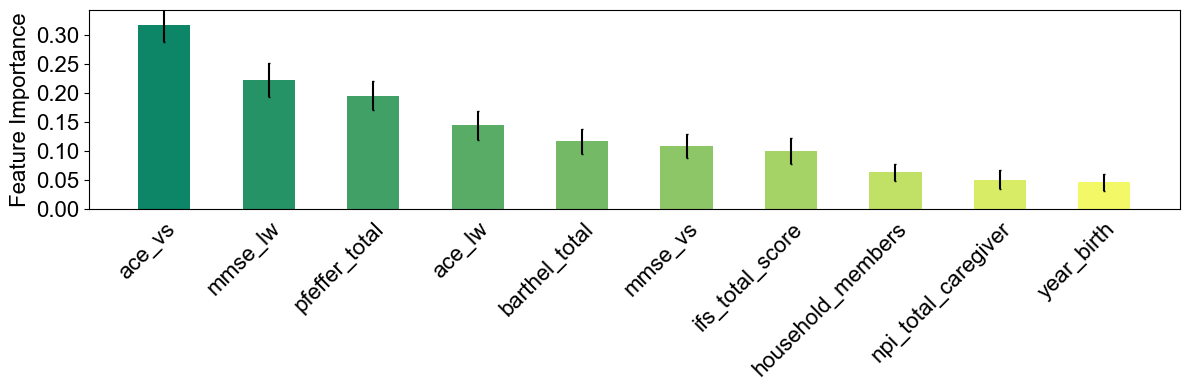

In [69]:
ml_plotting.plot_permutation_FIMP(top_10_poly, names='predictor', importances_col='mean', std_col='std')

#### Unseen data

In [70]:
poly = SVC(**poly_params)
poly=poly.fit(X_train, y_train)
y_pred = poly.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)


In [71]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/SVM_poly/poly_PFI.csv")

In [72]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}\n")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{p_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.5802
Accuracy: 0.4206
Recall: 0.88
F1: 0.4151
Precision:0.2716

Unseen Data ROC score: 		0.5802
Bootstrping test ROC score: 	0.7737


#### Shapley

In [73]:
poly_params['probability'] = True

In [74]:
# compute SHAP values
poly = SVC(**poly_params)
poly=poly.fit(X_train, y_train)

masker=shap.maskers.Independent(X_train, max_samples=1)
# explainer = shap.KernelExplainer(model=svc_rbf.predict, data=X_train, masker=masker)
explainer = shap.KernelExplainer(model=poly.predict_proba, data=masker.data)
shap_values = explainer.shap_values(X_train, masker = masker)
# explainer = shap.KernelExplainer(model.predict, X_train_summary, masker=background)

X does not have valid feature names, but SVC was fitted with feature names


  0%|          | 0/974 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

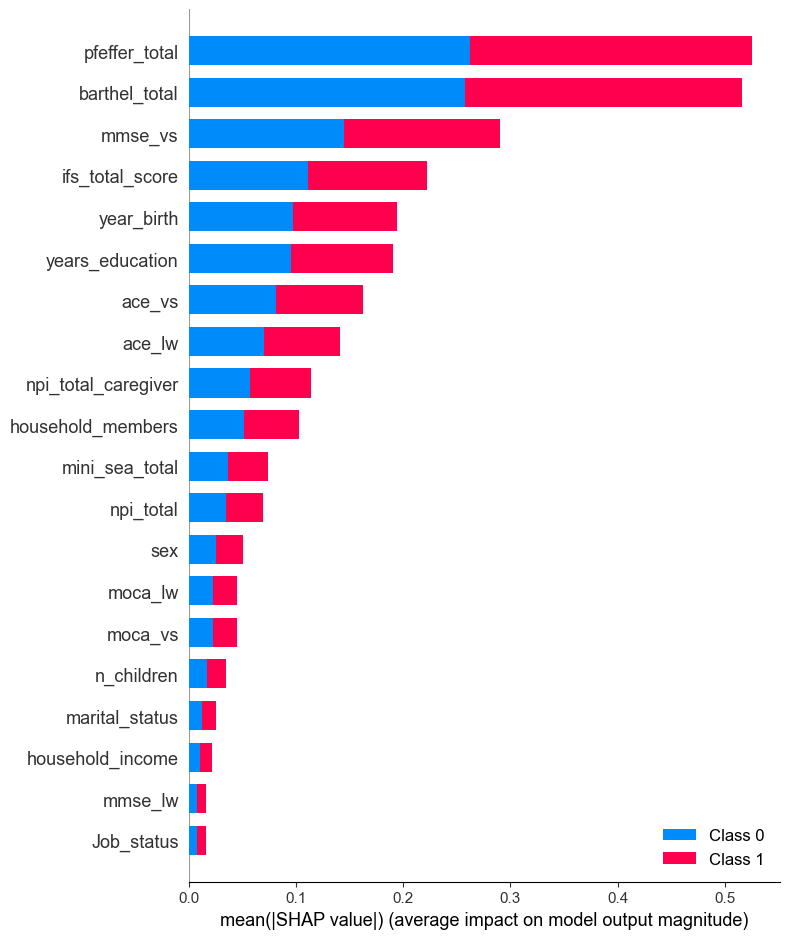

In [75]:
shap.summary_plot(shap_values, feature_names=X_train.columns)
# shap.summary_plot(shap_values[:,:,:1], feature_names=X_train.columns)

### XGBoost

#### Bootstrap

In [76]:
xgb_Model_res, xgb_CI_df, xgb_Model_res_r, xgb_ROC_AUC, xgbCM, xgb_ROC_chance, xgb_empirical_p_value, _ = bc.Bootstrap_XGB_classifier(
    data, 'diagnosis',  params=xgb_params, test_size=.2, scaler='MM', n_iter=n_iter, chance_model=True)

Iterating: 100%|██████████████████| 1000/1000 [39:30<00:00,  2.37s/it]

singular_matrix_errors (droped from results): 0
Eleapsed time:39.505614598592125 minutes
empirical p-value: 0.0


In [77]:
xgb_Model_res.to_csv(path_res+ "/XGBoost/xgb_Model_res.csv", index=False)
xgb_Model_res.mean()

Accuracy       0.837456
ROC_AUC        0.858319
Precision      0.723726
Recall         0.508652
Sensitivity    0.508652
Specificity    0.938966
F1             0.594525
Efron_pR2      0.349870
dtype: float64

In [78]:
xgb_Model_res_r.sort_values('Importance_gain_mean', ascending=False).to_csv(path_res+"/XGBoost/xgb_Model_res_r.csv", index=False)
xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
10,mini_sea_total,40.665,4.437394,6.396597,0.609792
9,marital_status,28.454,8.258577,3.834528,0.660686
20,years_education,27.044,3.781847,4.988967,0.620053
6,household_income,26.349,3.985107,4.470777,0.601608
19,year_birth,24.480,3.394573,16.344299,1.957863
8,ifs_total_score,24.009,4.424307,4.655502,0.858211
7,household_members,18.186,4.096362,4.670363,0.822633
16,npi_total_caregiver,15.863,4.009527,3.256760,0.761630
0,Job_status,13.246,3.879760,2.499826,0.519435
2,ace_vs,11.431,4.710991,5.126354,1.532133


In [79]:
xgb_CI_df.to_csv(path_res+ "/XGBoost/xgb_CI_df.csv", index=False)
xgb_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.022868,0.021614,0.027715,0.030986,0.030986,0.014838,0.030431,0.02956


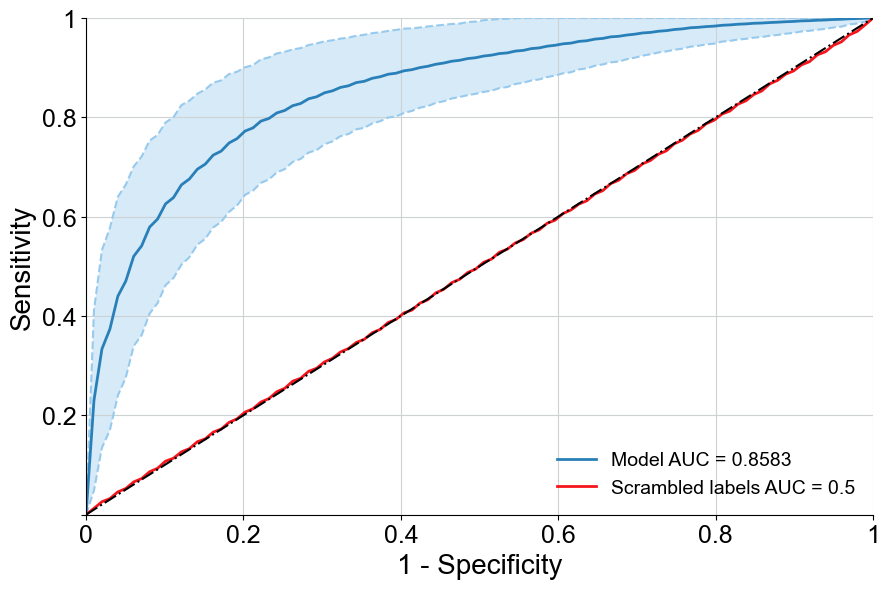

In [80]:
ml_plotting.plot_custom_roc_curve(xgb_ROC_AUC, xgb_ROC_chance, fname=path_res+ "/XGBoost/xgb_ROC.png")

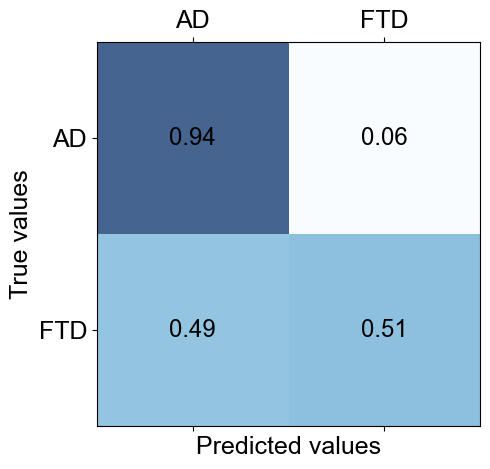

In [81]:
ml_plotting.plot_boostrap_CM(xgbCM, labels=['AD', 'FTD'],fname=path_res+ "/XGBoost/xgb_CM.png")

#### Permutation Feature importance

In [82]:
xgb_fimp = bc.permutation_FIMP( data, 'diagnosis', xgboost.XGBClassifier(), params=xgb_params, test_size=.3, n_repeats=1000, random_state=123)
xgb_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/XGBoost/xgb_PFI.csv")
top_10_xgb=xgb_fimp.sort_values('mean', ascending=False).head(10)

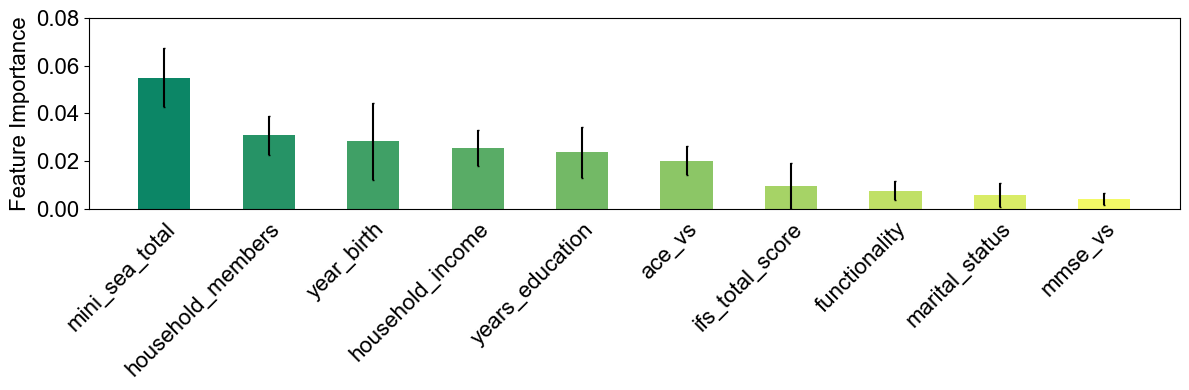

In [83]:
ml_plotting.plot_permutation_FIMP(top_10_xgb, names='predictor', importances_col='mean', std_col='std')

In [84]:
xgb_Model_res_r

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
0,Job_status,13.246000,3.879760,2.499826,0.519435
1,ace_lw,5.081053,2.992924,5.177472,2.591082
2,ace_vs,11.431000,4.710991,5.126354,1.532133
3,barthel_total,6.933401,3.467833,3.483414,1.447254
4,cognition,9.254016,4.410897,4.225185,2.068040
5,functionality,2.703980,1.790923,5.993130,3.032978
6,household_income,26.349000,3.985107,4.470777,0.601608
7,household_members,18.186000,4.096362,4.670363,0.822633
8,ifs_total_score,24.009000,4.424307,4.655502,0.858211
9,marital_status,28.454000,8.258577,3.834528,0.660686


In [85]:
top_10_xgb = xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)
top_10_xgb

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
10,mini_sea_total,40.665,4.437394,6.396597,0.609792
9,marital_status,28.454,8.258577,3.834528,0.660686
20,years_education,27.044,3.781847,4.988967,0.620053
6,household_income,26.349,3.985107,4.470777,0.601608
19,year_birth,24.480,3.394573,16.344299,1.957863
8,ifs_total_score,24.009,4.424307,4.655502,0.858211
7,household_members,18.186,4.096362,4.670363,0.822633
16,npi_total_caregiver,15.863,4.009527,3.256760,0.761630
0,Job_status,13.246,3.879760,2.499826,0.519435
2,ace_vs,11.431,4.710991,5.126354,1.532133


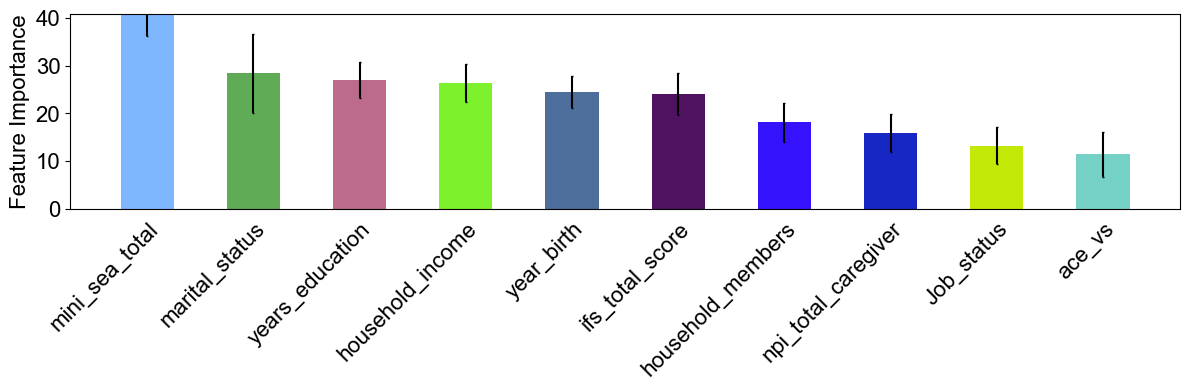

In [86]:
ml_plotting.plot_bootstrap_FIMP(top_10_xgb, 'variables','Importance_f_score_mean', 'Importance_f_score_std')

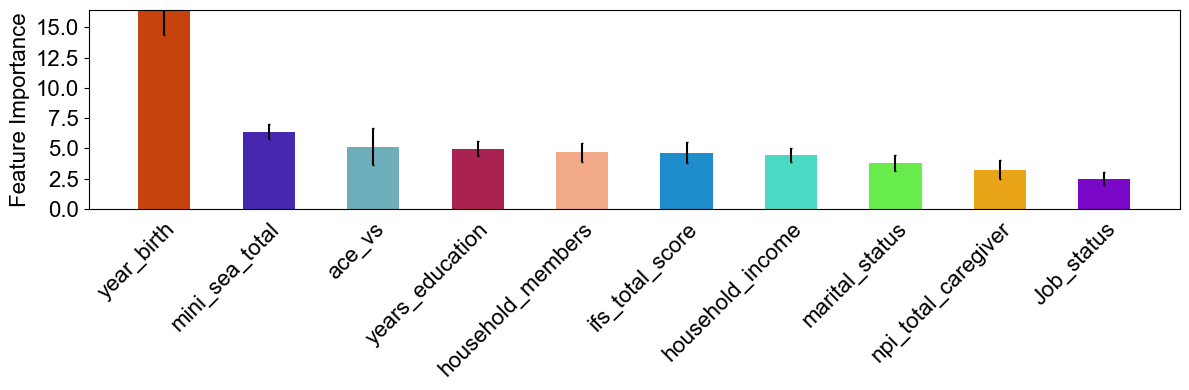

In [87]:
ml_plotting.plot_bootstrap_FIMP(top_10_xgb, 'variables','Importance_gain_mean', 'Importance_gain_std')

#### Unseen data

In [88]:
xgb = xgboost.XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)


In [89]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/XGBoost/xgb_PFI.csv")

In [90]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}\n")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{xgb_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.6295
Accuracy: 0.7944
Recall: 0.32
F1: 0.4211
Precision:0.6154

Unseen Data ROC score: 		0.6295
Bootstrping test ROC score: 	0.8583


#### Shapley

In [91]:
# # compute SHAP values
# explainer = shap.explainers.Tree(xgb, X_train, feature_names=X_train.columns.tolist())
# shap_values = explainer(X_train, check_additivity=False)

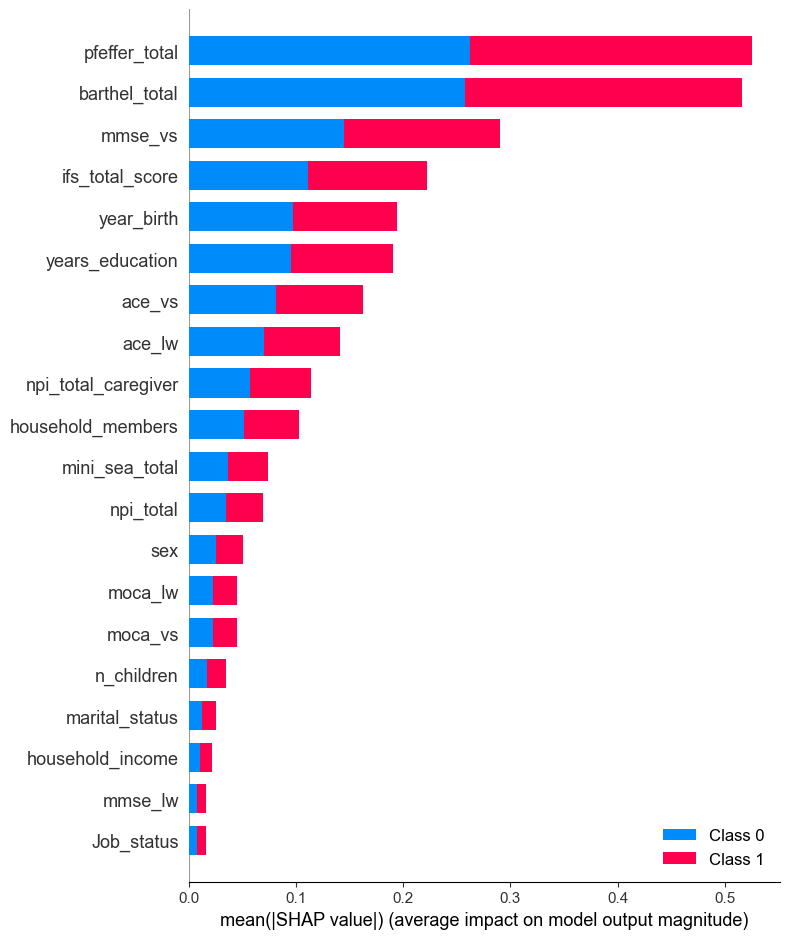

In [92]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

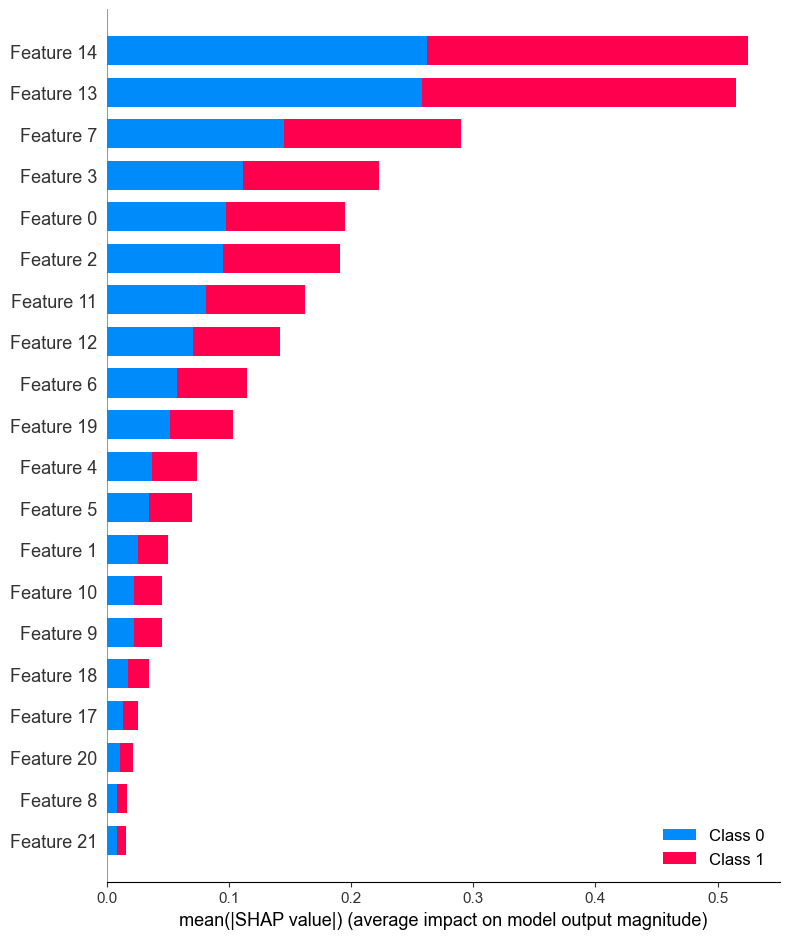

In [93]:
shap.summary_plot(shap_values)

In [94]:
#shap.plots.bar(shap_values)

### Sequential feature selector

#### RF

In [95]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [96]:
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits)

In [97]:
rf_params

{'n_estimators': 500,
 'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_split': 0.01,
 'min_samples_leaf': 0.01,
 'max_features': 10,
 'class_weight': 'balanced',
 'verbose': 0,
 'n_jobs': -1}

In [98]:
sfs_rfc = SFS(RandomForestClassifier(class_weight= 'balanced'), 
           k_features=len(X_train.columns), 
           forward=True, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [99]:
sfs_rfc = sfs_rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  22 | elapsed:    2.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    2.8s finished
Features: 1/22[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed:    2.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.6s finished
Features: 2/22[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.6s finished
Features: 3/22[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    2.0s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.7s finished
Features: 4/22[Parallel(n_jobs=-1)]: Using

In [100]:
pd.DataFrame.from_dict(sfs_rfc.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(15,)","[0.7476923076923077, 0.7569230769230769, 0.719...",0.74125,"(cognition,)",0.036197,0.016085,0.011374
2,"(4, 15)","[0.8092307692307692, 0.7569230769230769, 0.780...",0.782339,"(mini_sea_total, cognition)",0.048112,0.02138,0.015118
3,"(4, 15, 17)","[0.8246153846153846, 0.803076923076923, 0.8117...",0.81314,"(mini_sea_total, cognition, marital_status)",0.019914,0.00885,0.006258
4,"(4, 5, 15, 17)","[0.8492307692307692, 0.8215384615384616, 0.808...",0.82647,"(mini_sea_total, npi_total, cognition, marital...",0.038106,0.016933,0.011974
5,"(4, 5, 15, 17, 21)","[0.8615384615384616, 0.8338461538461538, 0.820...",0.838791,"(mini_sea_total, npi_total, cognition, marital...",0.038076,0.01692,0.011964
6,"(4, 5, 15, 16, 17, 21)","[0.8646153846153846, 0.8276923076923077, 0.833...",0.84188,"(mini_sea_total, npi_total, cognition, functio...",0.036546,0.01624,0.011484
7,"(0, 4, 5, 15, 16, 17, 21)","[0.8461538461538461, 0.8492307692307692, 0.833...",0.842906,"(year_birth, mini_sea_total, npi_total, cognit...",0.015492,0.006884,0.004868
8,"(0, 4, 5, 9, 15, 16, 17, 21)","[0.8492307692307692, 0.8523076923076923, 0.839...",0.847015,"(year_birth, mini_sea_total, npi_total, moca_v...",0.012278,0.005456,0.003858
9,"(0, 4, 5, 9, 15, 16, 17, 19, 21)","[0.8523076923076923, 0.8430769230769231, 0.839...",0.844964,"(year_birth, mini_sea_total, npi_total, moca_v...",0.012138,0.005394,0.003814
10,"(0, 4, 5, 6, 9, 15, 16, 17, 19, 21)","[0.8492307692307692, 0.8553846153846154, 0.830...",0.844954,"(year_birth, mini_sea_total, npi_total, npi_to...",0.024076,0.010699,0.007565


In [101]:
from sklearn.feature_selection import SequentialFeatureSelector as ssfs
from sklearn.feature_selection import RFECV

In [102]:
rfecv_rf = RFECV(RandomForestClassifier(class_weight= 'balanced'), step=1, min_features_to_select=5, cv=cv, scoring='roc_auc', verbose=1,
      n_jobs=-1, importance_getter='auto')

In [103]:
rfecv_rf=rfecv_rf.fit(X_train, y_train)

Fitting estimator with 22 features.


In [104]:
X_train.columns[rfecv_rf.support_]

Index(['year_birth', 'years_education', 'ifs_total_score', 'mini_sea_total',
       'npi_total', 'npi_total_caregiver', 'mmse_vs', 'mmse_lw', 'moca_vs',
       'moca_lw', 'ace_vs', 'ace_lw', 'barthel_total', 'pfeffer_total',
       'cognition', 'functionality', 'marital_status', 'n_children',
       'household_members', 'household_income', 'Job_status'],
      dtype='object')

### XBoost

In [105]:
sfs_xgb = SFS(xgboost.XGBClassifier(), 
           k_features=len(X_train.columns), 
           forward=True, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [106]:
sfs_xgb = sfs_xgb.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  22 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.6s finished
Features: 1/22[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.6s finished
Features: 2/22[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished
Features: 3/22[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.8s finished
Features: 4/22[Parallel(n_jobs=-1)]: Using

In [107]:
pd.DataFrame.from_dict(sfs_xgb.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(9,)","[0.7784615384615384, 0.76, 0.7901234567901234]",0.776195,"(moca_vs,)",0.027908,0.012402,0.008769
2,"(9, 12)","[0.7692307692307693, 0.7753846153846153, 0.799...",0.781333,"(moca_vs, ace_lw)",0.029273,0.013008,0.009198
3,"(9, 10, 12)","[0.7692307692307693, 0.7753846153846153, 0.799...",0.781333,"(moca_vs, moca_lw, ace_lw)",0.029273,0.013008,0.009198
4,"(1, 9, 10, 12)","[0.7784615384615384, 0.7784615384615384, 0.787...",0.78132,"(sex, moca_vs, moca_lw, ace_lw)",0.009097,0.004043,0.002858
5,"(1, 9, 10, 12, 21)","[0.8092307692307692, 0.7692307692307693, 0.790...",0.789528,"(sex, moca_vs, moca_lw, ace_lw, Job_status)",0.03676,0.016335,0.011551
6,"(1, 3, 9, 10, 12, 21)","[0.8, 0.796923076923077, 0.7932098765432098]",0.796711,"(sex, ifs_total_score, moca_vs, moca_lw, ace_l...",0.006247,0.002776,0.001963
7,"(0, 1, 3, 9, 10, 12, 21)","[0.8307692307692308, 0.8092307692307692, 0.796...",0.812099,"(year_birth, sex, ifs_total_score, moca_vs, mo...",0.031997,0.014219,0.010054
8,"(0, 1, 3, 9, 10, 12, 17, 21)","[0.8123076923076923, 0.8461538461538461, 0.820...",0.826483,"(year_birth, sex, ifs_total_score, moca_vs, mo...",0.0323,0.014354,0.01015
9,"(0, 1, 3, 9, 10, 12, 13, 17, 21)","[0.8307692307692308, 0.8492307692307692, 0.824...",0.834691,"(year_birth, sex, ifs_total_score, moca_vs, mo...",0.023939,0.010638,0.007522
10,"(0, 1, 3, 6, 9, 10, 12, 13, 17, 21)","[0.8584615384615385, 0.8430769230769231, 0.820...",0.840842,"(year_birth, sex, ifs_total_score, npi_total_c...",0.03461,0.01538,0.010875


In [108]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

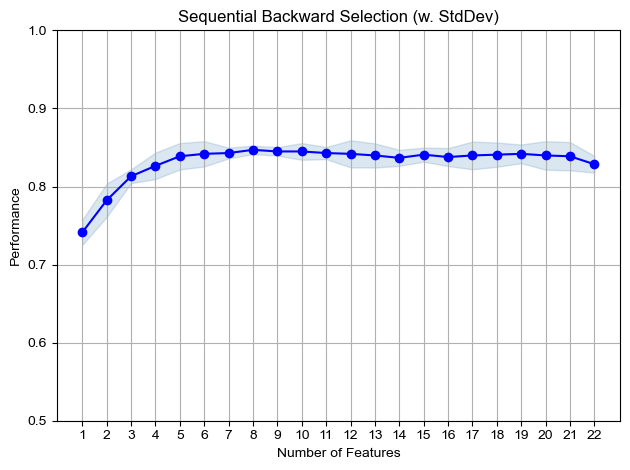

In [109]:
fig1 = plot_sfs(sfs_rfc.get_metric_dict(), kind='std_dev')


plt.ylim([0.5, 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

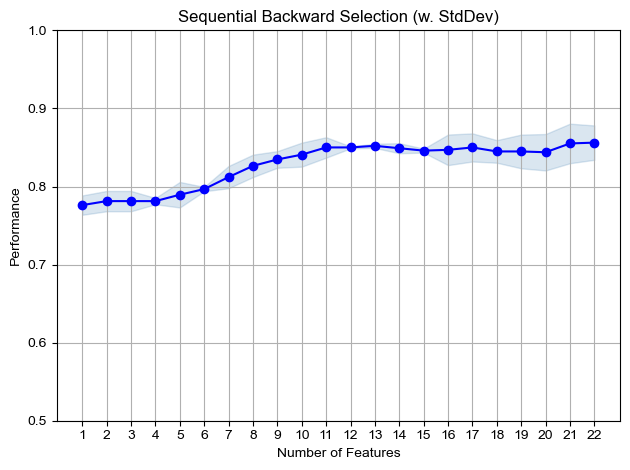

Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 featur

In [110]:
fig2 = plot_sfs(sfs_xgb.get_metric_dict(), kind='std_dev')


plt.ylim([0.5, 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()